# Interpreting the output of `find_adversarial_example`

Using the same example from the quickstart, we explore what information is available from the result of `find_adversarial_example`.

In [1]:
using MIPVerify
using Gurobi
using JuMP
using Images

mnist = MIPVerify.read_datasets("MNIST")
n1 = MIPVerify.get_example_network_params("MNIST.n1")
sample_image = MIPVerify.get_image(mnist.test.images, 1);

function view_diff(diff::Array{<:Real, 2})
    n = 1001
    colormap("RdBu", n)[ceil.(Int, (diff .+ 1) ./ 2 .* n)]
end;

┌ Info: Precompiling MIPVerify [e5e5f8be-2a6a-5994-adbb-5afbd0e30425]
└ @ Base loading.jl:1260


Let's take a look at the output dictionary that results from a solve.

In [2]:
d1 = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    10, 
    Gurobi.Optimizer,
    # OutputFlag=0 prevents any output from being printed out
    Dict("OutputFlag" => 0),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05),
    norm_order = Inf,
    tightening_algorithm = lp,
)

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only


  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds:  10%|██▎                    |  ETA: 0:03:39

Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:24
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only


Dict{Any,Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 15.6326
  :TotalTime          => 62.0275
  :Perturbation       => VariableRef[noname noname … noname noname]…
  :PerturbedInput     => VariableRef[noname noname … noname noname]…
  :TighteningApproach => "lp"
  :PerturbationFamily => linf-norm-bounded-0.05
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => GenericAffExpr{Float64,VariableRef}[-0.012063867412507…
  :PredictedIndex     => 8

### `:Model`

The model stores a lot of information. (Remember not to try to print large models!) 

In [3]:
m = d1[:Model];

Here are some `JuMP` methods you might find useful.

In [4]:
num_variables(m)

2411

In [5]:
num_constraints(m, VariableRef, MOI.GreaterThan{Float64})

2381

In [6]:
solve_time(m)

15.632591009140015

In this case, the lower bound on the objective and the best value we found is the same (but it can be different if we set time or other user limits)

In [7]:
objective_bound(m)

0.046084681588922705

In [8]:
objective_value(m)

0.046084681588922705

### `:PerturbationFamily`

Information on the family of perturbations we are searching over is stored in `:PerturbationFamily`.

In [9]:
d1[:PerturbationFamily]

linf-norm-bounded-0.05

### `:TargetIndexes`

The perturbed image is guaranteed to be classified in one of the target indexes. (Strictly speaking, we guarantee that the highest activation in the output layer among the target indexes is at least highest activation in the output layer among non-target indexes within a small numeric tolerance).

In [10]:
d1[:TargetIndexes]

1-element Array{Int64,1}:
 10

Multiple target labels and an inverted target selection are appropriately handled.

In [11]:
d2 = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    8,
    Gurobi.Optimizer,
    # OutputFlag=0 prevents any output from being printed out
    Dict("OutputFlag" => 0, "TimeLimit" => 5),
    pp = MIPVerify.LInfNormBoundedPerturbationFamily(0.05),
    norm_order = Inf,
    tightening_algorithm = lp,
    invert_target_selection = true,
)
d2[:TargetIndexes]

Academic license - for non-commercial use only
[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [1, 2, 3, 4, 5, 6, 7, 9, 10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00


Academic license - for non-commercial use only
Academic license - for non-commercial use only


9-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  7
  9
 10

### `:SolveStatus`

This is the result of the solve. [More information on solve statuses](https://jump.dev/MathOptInterface.jl/stable/apireference/#MathOptInterface.TerminationStatusCode)

We typically find an optimal solution:

In [12]:
d1[:SolveStatus]

OPTIMAL::TerminationStatusCode = 1

But we can encounter other solve statuses if (for instance) we set a time limit.

In [13]:
d2[:SolveStatus]

TIME_LIMIT::TerminationStatusCode = 12

### `:Perturbation`

This is the (pixel-wise) difference between the original image and the perturbed image.

In [14]:
perturbation = JuMP.value.(d1[:Perturbation])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0460847  0.0  0.0  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0460847

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0460847  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0460847

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0460847  …  0.0  0.0  0.0460847  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0460847  0.0  0.0

[:, :, 27, 1] =
 0.0460847  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0  0.0460847

[:, :, 28, 1] =
 0.0460847  0.0  0.0460847  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0460847  0.0

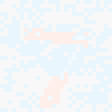

In [15]:
view_diff(perturbation[1, :, :, 1])

### `:PerturbedInput`

This is the perturbed image.

In [16]:
perturbed_input = JuMP.value.(d1[:PerturbedInput])

1×28×28×1 Array{Float64,4}:
[:, :, 1, 1] =
 0.0460847  0.0  0.0  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0460847

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0460847  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0460847

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0460847  …  0.0  0.0  0.0460847  0.0  0.0

...

[:, :, 26, 1] =
 0.0  0.0  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0460847  0.0  0.0

[:, :, 27, 1] =
 0.0460847  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0  0.0460847

[:, :, 28, 1] =
 0.0460847  0.0  0.0460847  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0460847  0.0

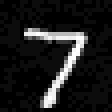

In [17]:
colorview(Gray, perturbed_input[1, :, :, 1])

We can verify that the perturbed input is in fact the sample image added to the perturbation.

In [18]:
all(perturbed_input == sample_image + perturbation)

false

### `:Output`

This is the calculated value of the activations of the final layer of the neural net with the perturbed input. Note that `output[10]` is (tied for) the largest element of the array.

In [19]:
output = JuMP.value.(d1[:Output])

10-element Array{Float64,1}:
  0.674945062874581
  0.6179790360668656
  0.3930321598089366
  0.2965618596703666
  0.24101053495483843
  0.16060021203574887
  0.5428526100447338
  4.288351484573902
 -0.22643018233076873
  4.288351484573896

We can verify that these activations are indeed accurate:

In [20]:
perturbed_input |> n1

10-element Array{Float64,1}:
  0.6749450628745901
  0.6179790360668731
  0.39303215980894035
  0.29656185967037274
  0.24101053495484248
  0.1606002120357537
  0.5428526100447416
  4.2883514845739015
 -0.22643018233076506
  4.288351484573905